In [2]:
import itertools as it
import networkx as nx
from collections import Counter
import copy
import matplotlib.pyplot as plt
import random
from fractions import Fraction
import math

def collapse(fraction):
    if fraction < 1:
        while fraction < 1:
            fraction *= Fraction(2, 1)
    elif fraction >= 2:
        while fraction >= 2:
            fraction *= Fraction(1, 2)
    return fraction

def hsPointToFR(point):
    fraction = Fraction(1, 1)
    for dim in point:
        if dim > 0:
            fraction = fraction * dim
        else:
            fraction = fraction * 1/abs(dim)
    return fraction
    
def pitches(iterable, r):
    for base in it.combinations_with_replacement(iterable, r - 1):
        split = tuple(list(g) for k, g in it.groupby(tuple(b for b in base if b != 1)))
        mults = list(it.product([-1, 1], repeat = len(split)))
        for mult in mults:
            yield tuple(it.chain(*[[val * mult[idx] for val in g] for idx, g in enumerate(split)]))

def expandPitch(pitch):
    num = 1;
    den = 1;
    expandedPitch = list(pitch)
    for dim in pitch:
        if dim > 0:
            num *= dim
        else:
            den *= abs(dim)
    fraction = num/den
    if fraction < 1:
        while fraction < 1:
            fraction *= 2
            expandedPitch = [2] + expandedPitch
    elif fraction >= 2:
        while fraction >= 2:
            fraction *= 1/2
            expandedPitch = [-2] + expandedPitch
    return tuple(expandedPitch)

def expandChord(chord):
    return tuple([expandPitch(p) for p in chord])

        
def transposePitch(pitch, trans):
    transposedPitch = list(pitch)
    for t in trans:
        if (t * -1) in transposedPitch:
            transposedPitch.remove(t * -1)
        else:
            transposedPitch.append(t)
    transposedPitch.sort(key=lambda val: abs(val))
    return transposedPitch
    
def transposeChord(chord, trans):
    transposedChord = list(chord)
    for pdx, pitch in enumerate(chord):
        transposedPitch = transposePitch(pitch, trans)
        transposedChord[pdx] = tuple(transposedPitch)
    return tuple(transposedChord)
    
def chords(pitches, r):
    def is_connected(iterable):
        points = comparitors = list(iterable)
        connectedPoints = []
        base = points[0]
        bIdxScroll = 0
        while True:
            for comp in comparitors:
                comps = sorted([base, comp], key=len, reverse=True)
                if ((Counter(comps[0]) - Counter(comps[1])).total() == 1) and (len(comps[0]) - len(comps[1]) == 1):
                    comparitors = connectedPoints = connectedPoints + comps
                    points.remove(base)
                    if comp in points:
                        points.remove(comp)
                    if(len(points) == 0):
                        return True
                    else:
                        base = points[0]
                        bIdxScroll = 0
                        break
            else:
                if bIdxScroll < (len(points) - 1):
                    bIdxScroll += 1
                    base = points[bIdxScroll]
                else:
                    return False
    def is_centered(iterable):
        return len(list(iterable)[0]) == 0
    #return filter(is_connected, it.takewhile(is_centered, it.combinations(pitches, r)))
    return {c for c in it.takewhile(is_centered, it.combinations(pitches, r)) if is_connected(c)}

def pitchDifference(frs):
    cents1 = (1200 * math.log(hsPointToFR(frs[0]), 2))
    cents2 = (1200 * math.log(hsPointToFR(frs[1]), 2))
    return abs(cents2 - cents1)

def difference(p1, p2):
    return transposePitch(p1, [p * -1 for p in p2])
        
def edges(chords):    
    def edgeDict(transposition, symDiff):
        dict = {}
        dict['melodic_movement'] = pitchDifference(symDiff)
        dict['transposition'] = transposition
        return dict
    def reverseDict(dict):
        revDict = copy.deepcopy(dict)
        if revDict['transposition'] != ():
            revDict['transposition'] = tuple(t * -1 for t in revDict['transposition'])
        return revDict
    def edgeData(iterable):
        [base, comp] = list(iterable)
        expandedBase = expandChord(base)
        expandedComp = expandChord(comp)
        transpositions = set([tuple(difference(pair[0], pair[1])) for pair in set(it.product(expandedBase, expandedComp))])
        edges = [(expandedBase, expandedComp, edgeDict(t, symDiff)) for t in transpositions if len(symDiff := list(set(expandedBase) ^ set(tChord := transposeChord(expandedComp, t)))) == 2]
        edges = edges + [(e[1], e[0], reverseDict(e[2])) for e in edges]
        if edges != []:
            return edges
        else:
            return None
    return list(it.chain(*[e for c in it.combinations(chords, 2) if (e := edgeData(c)) is not None]))

def graph(edges):
    G = nx.MultiDiGraph()
    G.add_edges_from(edges)
    return G

def hamiltonian(G):
    F = [(G,[list(G.nodes())[0]])]
    n = G.number_of_nodes()
    while F:
        graph,path = F.pop()
        confs = []
        neighbors = (node for node in graph.neighbors(path[-1]) 
                     if node != path[-1]) #exclude self loops
        for neighbor in neighbors:
            conf_p = path[:]
            conf_p.append(neighbor)
            conf_g = nx.Graph(graph)
            conf_g.remove_node(path[-1])
            confs.append((conf_g,conf_p))
        for g,p in confs:
            if len(p)==n:
                return p
            else:
                F.append((g,p))
    return None

def stochastic_hamiltonian(graph):
    check_graph = graph.copy()
    #next_node = random.choice(list(graph.nodes()))
    next_node = list(graph.nodes())[0]
    check_graph.remove_node(next_node)
    path = [next_node]
    while (nx.number_of_nodes(check_graph) > 0) and (len(path) < 5000):
        neighbors = graph[next_node]
        nd_list = list(graph.degree(list(neighbors)))
        neighbors, weights = zip(*[[n, 1/pow(d, 2) if n not in path else 0.0000001] for n, d in nd_list]) 
        next_node = random.choices(neighbors, weights=weights)[0]
        path.append(next_node)
        if next_node in check_graph.nodes:
            check_graph.remove_node(next_node)
    return [path, check_graph]

def stochastic_hamiltonian(graph):
    check_graph = graph.copy()
    #next_node = random.choice(list(graph.nodes()))
    next_node = list(graph.nodes())[0]
    check_graph.remove_node(next_node)
    path = []
    while (nx.number_of_nodes(check_graph) > 0) and (len(path) < 5000):
        outEdges = list(graph.out_edges(next_node, data=True))
        weights = [(1 if e[2]['melodic_movement'] < 200 else 0.001) *  (1 if e[1] not in [pE[0] for pE in path] else 0.0000001) for e in outEdges]
        edge = random.choices(outEdges, weights=weights)[0]
        next_node = edge[1]
        path.append(edge)
        if next_node in check_graph.nodes:
            check_graph.remove_node(next_node)
    return path

In [3]:
pSet = pitches([1, 3, 5], 4)
#print(len(list(pSet)))
cSet = chords(pSet, 4)
#print(cSet)
eSet = edges(cSet)
#for e in eSet:
#    print(e)
testGraph = graph(eSet)

In [4]:
len(testGraph.nodes)

76

In [5]:
len(testGraph.edges)

1770

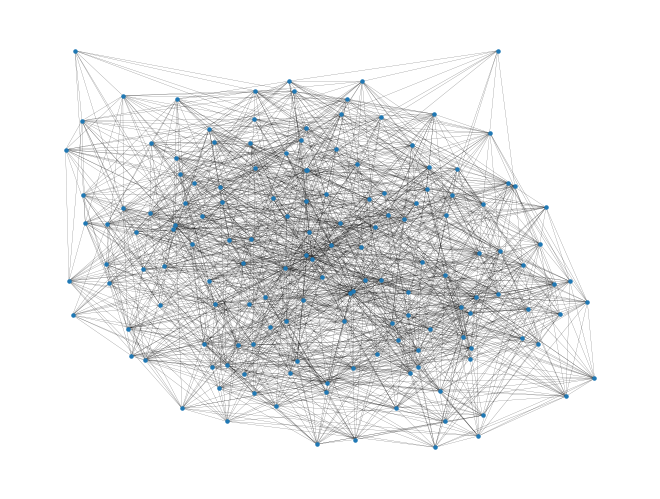

In [6]:
sGraph = nx.Graph(testGraph)
pos = nx.draw_spring(sGraph, node_size=5, width=0.1)

# larger figure size
plt.figure(1, figsize=(12,12)) 
nx.draw(sGraph, pos, node_size=5, width=0.1)
#plt.show()
plt.savefig('compact_sets.png', dpi=150)

In [7]:
def reconcilePath(ham):
    def sortByOther(c1, c2, trans):
        indices = list(range(len(c1)))
        sortedChord = copy.deepcopy(c2)
        for pitch in c2:
            transposedPitch = tuple(transposePitch(pitch, trans))
            if transposedPitch in c1:
                index = c1.index(transposedPitch)
                sortedChord[index] = pitch
                indices.remove(index)
            else:
                diff = pitch
        sortedChord[indices[0]] = diff
        return sortedChord
    rPath = [[[], [list(p) for p in ham[0][0]]]]
    for cdx in range(len(ham)-1):
        c1 = list(ham[cdx][0])
        c2 = list(ham[cdx][1])
        trans = list(ham[cdx][2]['transposition'])
        c2 = sortByOther(c1, c2, trans)
        ham[cdx+1][0] = c2
        rPath.append([trans, [list(p) for p in c2]])
    return rPath

ham = stochastic_hamiltonian(testGraph)
ham = [list(e) for e in ham]
print(len(ham))
for e in ham:
    print(e)
rPath = reconcilePath(ham)
rPath

79
[((), (-2, 3), (-2, -2, 5), (2, 3, -5)), ((), (2, 2, -3), (-2, 3), (-2, -2, 5)), {'melodic_movement': 182.4037121340599, 'transposition': ()}]
[((), (2, 2, -3), (-2, 3), (-2, -2, 5)), ((), (2, 2, -3), (-2, -2, 5), (-2, -2, -2, -2, 5, 5)), {'melodic_movement': 70.67242686428222, 'transposition': ()}]
[((), (2, 2, -3), (-2, -2, 5), (-2, -2, -2, -2, 5, 5)), ((), (2, 2, -3), (2, 2, 2, -5), (-2, -2, 5)), {'melodic_movement': 41.0588584054957, 'transposition': ()}]
[((), (2, 2, -3), (2, 2, 2, -5), (-2, -2, 5)), ((), (2, 2, 2, -5), (-2, -2, 5), (2, 2, 2, 2, 2, -5, -5)), {'melodic_movement': 70.67242686428204, 'transposition': ()}]
[((), (2, 2, 2, -5), (-2, -2, 5), (2, 2, 2, 2, 2, -5, -5)), ((), (2, 2, -3), (2, 2, 2, -5), (2, 2, 2, 2, 2, -5, -5)), {'melodic_movement': 111.73128526977763, 'transposition': ()}]
[((), (2, 2, -3), (2, 2, 2, -5), (2, 2, 2, 2, 2, -5, -5)), ((), (2, 2, 2, -5), (2, 3, -5), (2, 2, 2, 2, 2, -5, -5)), {'melodic_movement': 182.4037121340599, 'transposition': ()}]
[((),

[[[], [[], [-2, 3], [-2, -2, 5], [2, 3, -5]]],
 [[], [[], [-2, 3], [-2, -2, 5], [2, 2, -3]]],
 [[], [[], [-2, -2, -2, -2, 5, 5], [-2, -2, 5], [2, 2, -3]]],
 [[], [[], [2, 2, 2, -5], [-2, -2, 5], [2, 2, -3]]],
 [[], [[], [2, 2, 2, -5], [-2, -2, 5], [2, 2, 2, 2, 2, -5, -5]]],
 [[], [[], [2, 2, 2, -5], [2, 2, -3], [2, 2, 2, 2, 2, -5, -5]]],
 [[], [[], [2, 2, 2, -5], [2, 3, -5], [2, 2, 2, 2, 2, -5, -5]]],
 [[-2, 3, 3, -5],
  [[], [2, 2, 2, 2, -3, -3], [2, 2, -3], [2, 2, 2, 2, 2, 2, -3, -3, -5]]],
 [[2, 2, 2, 2, 2, 2, 2, -3, -3, -3, -5],
  [[], [-2, -2, -2, 3, 5], [-2, -2, -2, -2, -2, 3, 3, 5], [-2, 3]]],
 [[], [[], [-2, -2, -2, 3, 5], [2, 2, -3], [-2, 3]]],
 [[], [[], [-2, -2, -2, 3, 5], [2, 3, -5], [-2, 3]]],
 [[], [[], [2, 2, 2, 2, 3, -5, -5], [2, 3, -5], [-2, 3]]],
 [[], [[], [2, 2, 2, 2, 3, -5, -5], [2, 3, -5], [2, 2, 2, -5]]],
 [[2, 2, 2, 2, -3, -5], [[], [3, 3, -5], [-2, -2, -2, 3, 3], [-2, 3]]],
 [[], [[], [-2, -2, -2, -2, 3, 3, 3], [-2, -2, -2, 3, 3], [-2, 3]]],
 [[-2, -2, -2, -2, 

In [8]:
def pathToChords(path):
    curRoot = Fraction(1, 1)
    chords = []
    for trans, points in path:
        curRoot = curRoot * hsPointToFR(trans)
        chord = [float(curRoot * hsPointToFR(p)) for p in points]
        chords.append(chord)
    return chords

fPath = pathToChords(rPath)
len(set([tuple(p) for p in fPath]))
fPath

[[1.0, 1.5, 1.25, 1.2],
 [1.0, 1.5, 1.25, 1.3333333333333333],
 [1.0, 1.5625, 1.25, 1.3333333333333333],
 [1.0, 1.6, 1.25, 1.3333333333333333],
 [1.0, 1.6, 1.25, 1.28],
 [1.0, 1.6, 1.3333333333333333, 1.28],
 [1.0, 1.6, 1.2, 1.28],
 [0.9, 1.6, 1.2, 1.28],
 [0.8533333333333334, 1.6, 1.2, 1.28],
 [0.8533333333333334, 1.6, 1.1377777777777778, 1.28],
 [0.8533333333333334, 1.6, 1.024, 1.28],
 [0.8533333333333334, 1.6384, 1.024, 1.28],
 [0.8533333333333334, 1.6384, 1.024, 1.3653333333333333],
 [0.9102222222222223, 1.6384, 1.024, 1.3653333333333333],
 [0.9102222222222223, 1.536, 1.024, 1.3653333333333333],
 [0.96, 1.536, 1.024, 1.3653333333333333],
 [0.96, 1.536, 1.024, 1.44],
 [0.96, 1.536, 1.08, 1.44],
 [0.96, 1.536, 1.152, 1.44],
 [1.024, 1.536, 1.152, 1.44],
 [1.08, 1.536, 1.152, 1.44],
 [1.08, 1.62, 1.152, 1.44],
 [1.08, 1.8, 1.152, 1.44],
 [1.08, 1.8, 1.125, 1.44],
 [1.08, 1.8, 1.2, 1.44],
 [1.08, 1.8, 1.2, 1.35],
 [1.08, 1.8, 1.125, 1.35],
 [1.08, 1.6875, 1.125, 1.35],
 [1.0546875, 1.6

In [284]:
# Opening a file in write mode{
file = open("seq.txt", "w+")

# Converting the array to a string and writing to the file
content = str(fPath)
file.write(content)

# Closing the file
file.close()

In [279]:
for edge in list(testGraph.edges(data=True))[:1000]:
    print(edge)

(((), (2, 2, 2, -7), (2, 2, 2, 2, 2, 2, -5, -7), (2, 2, 2, 2, 3, -5, -7)), ((), (2, 2, 2, 2, -13), (2, 2, 2, 2, 2, 2, 2, -5, -13), (2, 2, 2, 2, 2, 3, -5, -13)), {'melodic_movement': 128.2982446998143, 'transposition': (-2, -7, 13)})
(((), (2, 2, 2, -7), (2, 2, 2, 2, 2, 2, -5, -7), (2, 2, 2, 2, 3, -5, -7)), ((), (2, 2, 2, -5), (2, 3, -5), (3, 3, -5)), {'melodic_movement': 1248.7703813968149, 'transposition': (2, 2, 2, -7)})
(((), (2, 2, 2, -7), (2, 2, 2, 2, 2, 2, -5, -7), (2, 2, 2, 2, 3, -5, -7)), ((), (2, 2, 2, -5), (2, 3, -5), (-2, -5, 11)), {'melodic_movement': 396.17832203079695, 'transposition': (2, 2, 2, -7)})
(((), (2, 2, 2, -7), (2, 2, 2, 2, 2, 2, -5, -7), (2, 2, 2, 2, 3, -5, -7)), ((), (2, 2, 2, -5), (-2, -2, 7), (2, 3, -5)), {'melodic_movement': 1200.0, 'transposition': (2, 2, 2, -7)})
(((), (2, 2, 2, -7), (2, 2, 2, 2, 2, 2, -5, -7), (2, 2, 2, 2, 3, -5, -7)), ((), (2, 2, 2, -5), (-2, -2, -2, 13), (2, 3, -5)), {'melodic_movement': 1071.7017553001858, 'transposition': (2, 2, 2, 

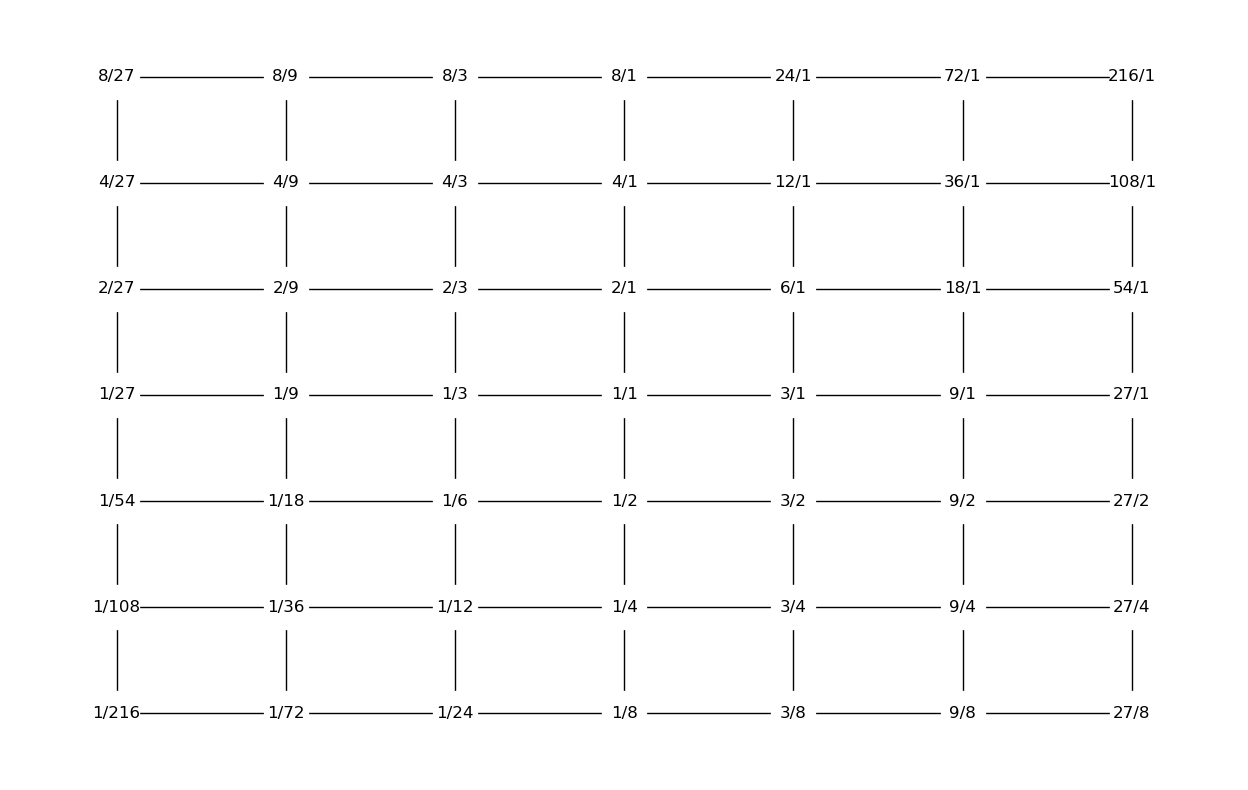

In [161]:
import networkx as nx
from matplotlib import pyplot as plt
import math

G = nx.grid_graph(dim=(range(-3, 4), range(-3, 4)))

def getLabel(x, y):
    num = 1
    den = 1
    if x >= 0:
        num *= math.pow(3, x)
    else:
        den *= math.pow(3, abs(x))
    if y >= 0:
        num *= math.pow(2, y)
    else:
        den *= math.pow(2, abs(y))
    return str(int(num)) + "/" + str(int(den))
    
        

plt.figure(figsize=(10 * math.log2(3), 10 * math.log2(2)))
#plt.figure(figsize=(10, 10))
pos = {(x, y):(x * math.log2(3), y * math.log2(2)) for x,y in G.nodes()}
labels = {(x, y):getLabel(x, y) for x,y in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels)
nx.draw(G, pos=pos, 
        node_color='white', 
        with_labels=False,
        node_size=1000)

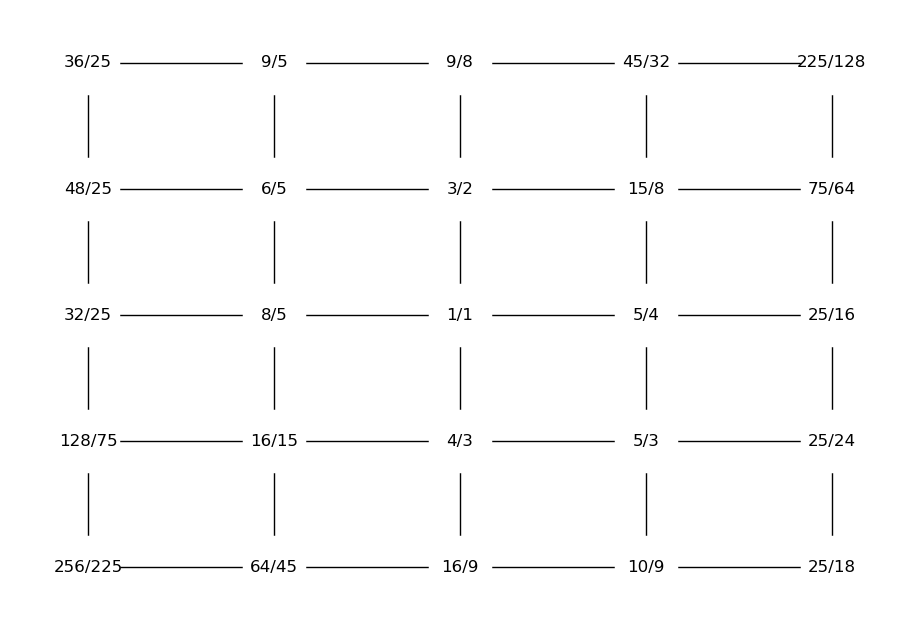

In [160]:
import networkx as nx
from matplotlib import pyplot as plt
import math

G = nx.grid_graph(dim=(range(-2, 3), range(-2, 3)))

def collapseLabel(fraction):
    if fraction < 1:
        while fraction < 1:
            fraction *= Fraction(2, 1)
    elif fraction >= 2:
        while fraction >= 2:
            fraction *= Fraction(1, 2)
    return fraction
    
def getLabel(x, y):
    num = 1
    den = 1
    if x >= 0:
        num *= math.pow(5, x)
    else:
        den *= math.pow(5, abs(x))
    if y >= 0:
        num *= math.pow(3, y)
    else:
        den *= math.pow(3, abs(y))
    fraction = collapse(Fraction(int(num), int(den)))
    num = fraction.numerator
    den = fraction.denominator
    return str(int(num)) + "/" + str(int(den))

plt.figure(figsize=(5 * math.log2(5), 5 * math.log2(3)))
#plt.figure(figsize=(10, 10))
pos = {(x, y):(x, y) for x,y in G.nodes()}
labels = {(x, y):getLabel(x, y) for x,y in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels)
nx.draw(G, pos=pos, 
        node_color='white', 
        with_labels=False,
        node_size=2000)

In [44]:
for node in list(testGraph.nodes)[2:3]:
    edges = list(testGraph.out_edges(node, data=True))
    for edge in edges:
        if list(edge)[2]['transposition'] != ():
            print(edge)

(((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (-2, 3), (-2, -2, 5), (2, 3, -5)), {'melodic_movement': 631.2825740011051, 'transposition': (2, 3, -5)})
(((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (-2, 3), (-2, -2, 5), (-3, 5)), {'melodic_movement': 1200.0, 'transposition': (2, 3, -5)})
(((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (-2, -2, 5), (-2, -2, -2, 3, 5), (-2, -2, -2, -2, 5, 5)), {'melodic_movement': 70.67242686428227, 'transposition': (2, 2, 2, 3, -5, -5)})
(((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (-2, 3), (-2, -2, 5), (-2, -2, -2, -2, 5, 5)), {'melodic_movement': 1088.2687147302222, 'transposition': (2, 3, -5)})
(((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (-2, -2, 5), (-2, -2, -2, -2, 5, 5), (-2, -2, -2, -3, 5, 5)), {'melodic_movement': 1088.2687147302224, 'transposition': (2, 2, 2, 3, -5, -5)})
(((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (2, 2, -3), (2, 2, 2, -5), (2, 2, 2, 2, -3, -5)), {'melodic_movement': 203.91000173077484, 'transposition': (-2, -2, -2, 3, 3)})
(((), 

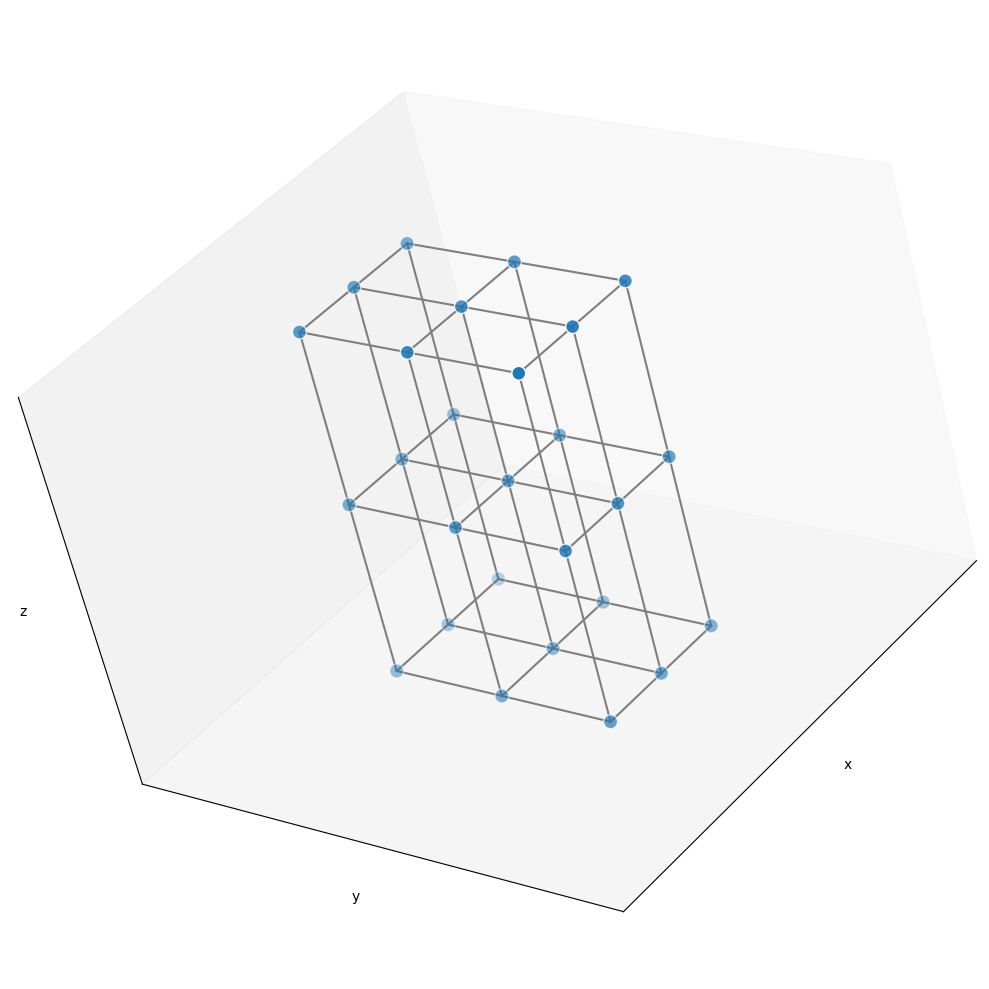

In [251]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# The graph to visualize
G = nx.grid_graph(dim=(range(-1, 2), range(-1, 2), range(-1, 2)))

# 3d spring layout
#pos = nx.spring_layout(G, dim=3, seed=779)
pos = {(x, y, z):(math.log2(2) * x, math.log2(3) * y, math.log2(5) * z) for x,y,z in G.nodes()}
# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=100, ec="w")

ax.view_init(elev=30, azim=45, roll=15)

ax.axis('equal')

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()

In [31]:
from tikzpy import TikzPicture

def collapseLabel(fraction):
    if fraction < 1:
        while fraction < 1:
            fraction *= Fraction(2, 1)
    elif fraction >= 2:
        while fraction >= 2:
            fraction *= Fraction(1, 2)
    return fraction

def getLabel(x, y, z, collapse = False):
    num = 1
    den = 1
    if x >= 0:
        num *= math.pow(3, x)
    else:
        den *= math.pow(3, abs(x))
        
    if y >= 0:
        num *= math.pow(5, y)
    else:
        den *= math.pow(5, abs(y))
        
    if z >= 0:
        num *= math.pow(2, z)
    else:
        den *= math.pow(2, abs(z))
    if collapse:
        fraction = collapseLabel(Fraction(int(num), int(den)))
    else:
        fraction = Fraction(int(num), int(den))
    num = fraction.numerator
    den = fraction.denominator
    return str(int(num)) + "/" + str(int(den))
    
def chord2Points(chord):
    points = []
    for n in chord:
        counter = Counter(n)
        points.append(tuple([counter[d] - counter[-d] for d in [2, 3, 5]]))
    return tuple(points)

def genLattice(chord = None, ranges = None, filename = "tikz", collapse = False,  scale = 1):

    dx = math.log2(3) * scale
    dy = math.log2(5) * scale
    dz = math.log2(2) * scale

    if chord:
        set = chord2Points(chord)

    if ranges:
        rz,rx,ry = ranges
    else:
        rz,rx,ry = [[min(t), max(t) + 1] for t in list(zip(*set))]

    if collapse:
        rz = [0, 1]
    
    tikz = TikzPicture(center=True)
    tikz.set_tdplotsetmaincoords(30, -30)
    tikz.options = "tdplot_main_coords"
    
    for x in range(*rx):
        for y in range(*ry):
            for z in range(*rz):
                line = tikz.line((x * dx - dx / 2, y * dy, z * dz), (x * dx + dx / 2, y * dy, z * dz), options="thick, black, -")
                line = tikz.line((x * dx, y * dy - dy / 2, z * dz), (x * dx, y * dy + dy / 2, z * dz), options="thick, black, -")
                if not collapse:
                    line = tikz.line((x * dx, y * dy, z * dz - dz / 2), (x * dx, y * dy, z * dz + dz / 2), options="thick, black, -")
                node = tikz.node((x * dx, y * dy, z * dz), options="draw, fill=white, scale=0.5", text=getLabel(x,y,z, collapse))

    if chord:
        for e in set:
            z,x,y = e
            if collapse:
                z = 0
            line = tikz.line((x * dx - dx / 2, y * dy, z * dz), (x * dx + dx / 2, y * dy, z * dz), options="thick, black, -")
            line = tikz.line((x * dx, y * dy - dy / 2, z * dz), (x * dx, y * dy + dy / 2, z * dz), options="thick, black, -")
            if not collapse:
                line = tikz.line((x * dx, y * dy, z * dz - dz / 2), (x * dx, y * dy, z * dz + dz / 2), options="thick, black, -")
            node = tikz.node((x * dx, y * dy, z * dz), options="draw, fill=yellow, scale=0.5", text=getLabel(x,y,z, collapse))

    tikz.compile(filename + ".pdf", True)
    
    texFile = open(filename + ".tex", "w+")
    texFile.write(tikz.code())
    texFile.close()

In [72]:
edge = (((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (2, 2, -3), (-2, 3), (-2, -2, 5)), {'melodic_movement': 813.6862861351653, 'transposition': (2, 3, -5)})
chord = transposeChord(edge[0], (-2, -3, 5))
#genLattice(chord, path="figure.pdf", collapse=False)
genLattice(chord, ranges=[[-2, 2], [-2, 2], [-2, 2]], filename="compact_set_1_transposed_expanded_padded", collapse=False, scale=2)

Rc files read:
  NONE
Latexmk: Run number 1 of rule 'pdflatex'
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Arch Linux) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
Latexmk: Getting log file 'tmp/tex_file.log'



In [79]:
edge = (((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (2, 2, -3), (-2, 3), (-2, -2, 5)), {'melodic_movement': 813.6862861351653, 'transposition': (2, 3, -5)})
chord = transposeChord(edge[0], (-2, -3, 5))
#genLattice(chord, path="figure.pdf", collapse=False)
genLattice(chord, ranges=[[-2, 2], [-1, 3], [-1, 2]], filename="compact_set_1_transposed_expanded_padded", collapse=False, scale=2)

Rc files read:
  NONE
Latexmk: Run number 1 of rule 'pdflatex'
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Arch Linux) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
Latexmk: Getting log file 'tmp/tex_file.log'



In [80]:
edge = (((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (2, 2, -3), (-2, 3), (-2, -2, 5)), {'melodic_movement': 813.6862861351653, 'transposition': (2, 3, -5)})
chord = edge[0]
#genLattice(chord, path="figure.pdf", collapse=False)
genLattice(chord, ranges=[[-2, 2], [-1, 3], [-1, 2]], filename="compact_set_1_expanded_padded", collapse=False, scale=2)

Rc files read:
  NONE
Latexmk: Run number 1 of rule 'pdflatex'
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Arch Linux) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
Latexmk: Getting log file 'tmp/tex_file.log'

